In [12]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [13]:
%load_ext autoreload
%autoreload 2

import os 

import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

import numpy as np
import scipy

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, LogisticRegressionLoss
from methods import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
class RosenbrockFunction(BaseOracle):
    
    def func(self, x):
        out = 0.0
        for i in range(len(x) - 1):
            out += 100 * (x[i + 1] - x[i]**2)**2 + (1 - x[i])**2
        return out

    def grad(self, x):
        n = len(x)
        grad = np.zeros_like(x)
        
        for i in range(n):
            if i == 0:
                grad[i] = -400 * x[i] * (x[i + 1] - x[i]**2) - 2 * (1 - x[i])
            elif i == n - 1:
                grad[i] = 200 * (x[i] - x[i-1]**2)
            else:
                grad[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])

        return grad
    
    def hess(self, x):
        n = len(x)
        H = np.zeros((n, n))
        
        for i in range(n):
            if i == 0:
                H[i, i] = 1200 * x[i]**2 - 400 * x[i+1] + 2
                H[i, i+1] = -400 * x[i]
            elif i == n - 1:
                H[i, i] = 200
                H[i, i-1] = -400 * x[i-1]
            else:
                H[i, i] = 202 + 1200 * x[i]**2 - 400 * x[i+1]
                H[i, i-1] = -400 * x[i-1]
                H[i, i+1] = -400 * x[i]
                
        return H


In [15]:
def train_loop(w_0: np.array, n_steps: int, optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # parameters
    w = w_0.copy()    
    w_star = np.ones_like(w)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = RosenbrockFunction()
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
    
    loss = np.inf
    
    for step in range(n_steps):
        
        if loss <= 1e-12:
            break
        
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)

        optim.step(oracle=loss_function)
        
        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm_sq"].append(np.linalg.norm(grad) ** 2)
        history["time"].append(time)
        history["lr"].append(optim.lr)
        history["w_diff"].append(np.linalg.norm(w - w_star) ** 2)
    
    return history

In [16]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        
    max_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        max_line.append(np.max(values_at_position))
        
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        min_line.append(np.min(values_at_position))
        
    return mean_line, max_line, min_line

def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markersizes=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, ylims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if f_star is None:
        f_star = np.min([x["loss"] for x in histories])
    else:
        f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m, ms in zip(histories, labels, colors, linestyles, linewidths, markers, markersizes):
        # f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        
        # markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(history["loss"]) - 2, len(history["loss"]) // 10)]
        
        # ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markersize=ms)
        # ax[1].plot(history["lr"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markersize=ms)
      
        
        f_suboptim = [x["loss"] / x["loss"][0] for x in history]
        mean_line, max_line, min_line = mean_max_min(f_suboptim)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(mean_line) - 2, len(mean_line) // 10)]
        ax[0].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[0].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markersize=ms)

        lrs = [x["lr"] for x in history]
        mean_line, max_line, min_line = mean_max_min(lrs)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))        
        ax[1].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[1].plot(x, mean_line, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markersize=ms)
        

    if f_star.sum() == 0.0:
        ax[0].set_ylabel(r"$f(x_k)/f(x_0)$")
        ax[1].set_ylabel(r"$f(x_k)/f(x_0)$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")
        ax[1].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")


    # ax[2].set_ylabel(r"$\| x_k - x^* \|_2^2$")

    ax[1].set_ylabel("stepsize")

    ax[0].set_xlabel("Steps")
    ax[1].set_xlabel("Steps")


    # if xlims is not None:
    #     ax[0].set_xlim(left=xlims[0], right=xlims[1])
    #     ax[1].set_xlim(right=xlims[1])

    if ylims is not None:
        ax[0].set_ylim(bottom=ylims[0][0])
        # ax[1].set_ylim(bottom=ylims[1][0])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    # ax[2].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show() 

In [30]:
n_steps = 1000
dim = 40

w_0s = []
for seed in range(0, 10):
    np.random.seed(seed)
    w_0s.append(np.random.randn(dim) * 20)

In [18]:
np.random.seed(0)

histories = []
labels = []

# # Damped Newton
# lr = 0.01
# hist_with_seeds = []
# for w_0 in w_0s:
#     hist = train_loop(w_0, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
#     hist_with_seeds.append(hist)
# histories.append(hist_with_seeds)
# labels.append(f"Newton, lr={lr}")

# GRLS
hist_with_seeds = []
for w_0 in w_0s:
    hist = train_loop(w_0, n_steps=n_steps, optimizer=GRLS, verbose=False)
    hist_with_seeds.append(hist)
histories.append(hist_with_seeds)
labels.append("GRLS")

/home/farshed.abdukhakimov/projects/root-newton/methods.py:618: RuntimeWarning: divide by zero encountered in scalar divide
  new_expr = (oracle.func(new_params) - oracle.func(self.params)) / ny_norm_squared


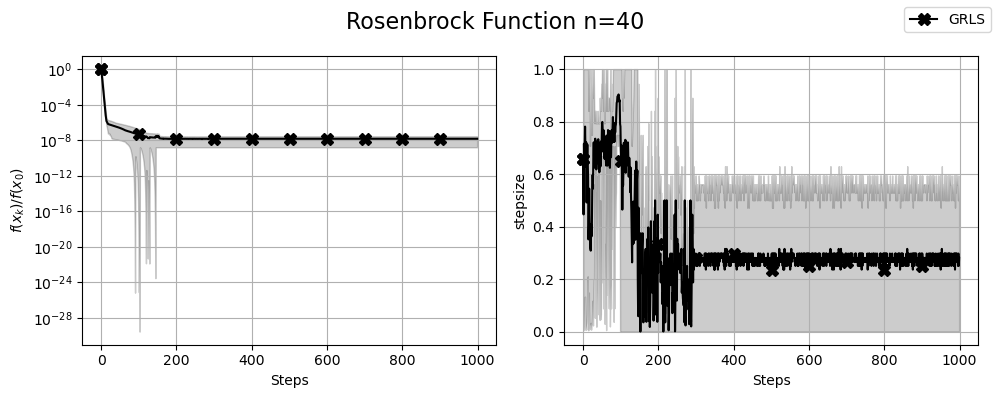

In [19]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "red", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.5, 1.0, 2.0, 2.0, 1.0],
        markers=["X", ".", "v", "s", "p"],
        markersizes=[8, 10, 8, 6, 6],
        suptitle=f"Rosenbrock Function n={dim}",
        f_star=0.0,)

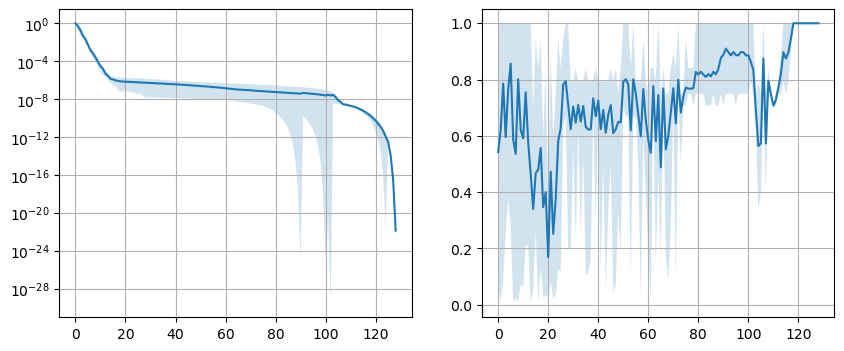

In [172]:


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
 
for history, label in zip(histories, labels):
    
    f_suboptim = [x["loss"] / x["loss"][0] for x in history]
    mean_line, max_line, min_line = mean_max_min(f_suboptim)

    x = np.linspace(0, len(mean_line) - 1, len(mean_line))

    ax[0].fill_between(x, max_line, min_line, alpha=0.2) 
    ax[0].semilogy(x, mean_line)
    

    lrs = [x["lr"] for x in history]
    mean_line, max_line, min_line = mean_max_min(lrs)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))

    ax[1].fill_between(x, max_line, min_line, alpha=0.2) 
    ax[1].plot(x, mean_line)


ax[0].grid()
ax[1].grid()

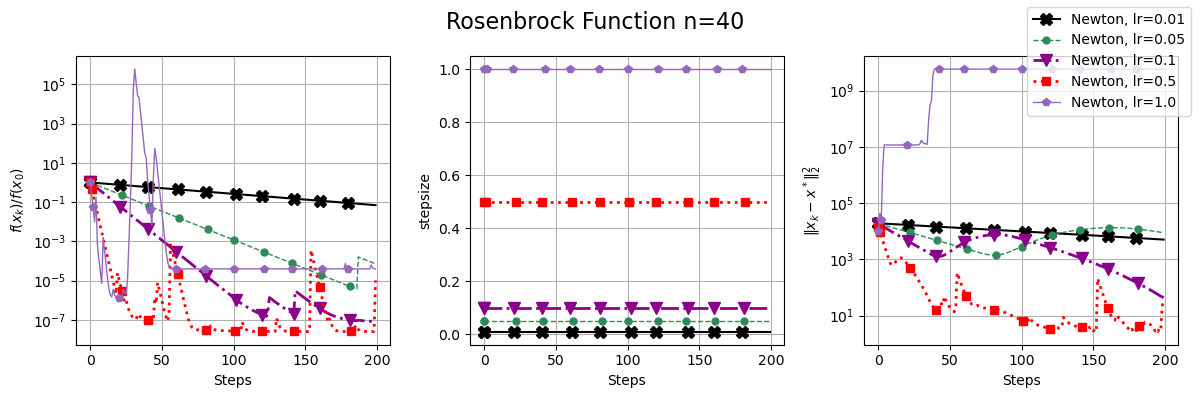

In [34]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "red", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.5, 1.0, 2.0, 2.0, 1.0],
        markers=["X", ".", "v", "s", "p"],
        markersizes=[8, 10, 8, 6, 6],
        suptitle=f"Rosenbrock Function n={dim}",
        f_star=0.0,)
        # filename=f"logreg_linesearch_{dataset_name}.pdf")

In [31]:
np.random.seed(0)

histories = []
labels = []

# Damped Newton
lr = 0.1
hist_with_seeds = []
for w_0 in w_0s:
    hist = train_loop(w_0, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
    hist_with_seeds.append(hist)
histories.append(hist_with_seeds)
labels.append(f"Newton, lr={lr}")

# Armijo Newton
hist_with_seeds = []
for w_0 in w_0s:
    hist = train_loop(w_0, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
    hist_with_seeds.append(hist)
histories.append(hist_with_seeds)
labels.append(r"Armijo Newton")


# Greedy Newton
hist_with_seeds = []
for w_0 in w_0s:
    hist = train_loop(w_0, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
    hist_with_seeds.append(hist)
histories.append(hist_with_seeds)
labels.append(r"Greedy Newton")

# GRLS
hist_with_seeds = []
for w_0 in w_0s:
    hist = train_loop(w_0, n_steps=n_steps, optimizer=GRLS, verbose=False)
    hist_with_seeds.append(hist)
histories.append(hist_with_seeds)
labels.append("GRLS")

/home/farshed.abdukhakimov/projects/root-newton/methods.py:618: RuntimeWarning: divide by zero encountered in scalar divide
  new_expr = (oracle.func(new_params) - oracle.func(self.params)) / ny_norm_squared


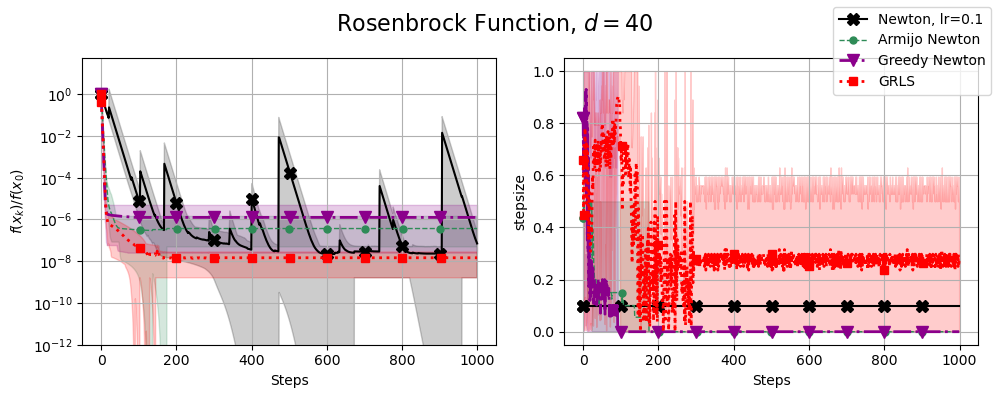

In [32]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "red", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.5, 1.0, 2.0, 2.0, 1.0],
        markers=["X", ".", "v", "s", "p"],
        markersizes=[8, 10, 8, 6, 6],
        suptitle=r"Rosenbrock Function, $d={0}$".format(dim),
        f_star=0.0,
        ylims=[[1e-12, 0.0]],
        filename=f"rosenbrock_linesearch_seed_10.pdf"
        )

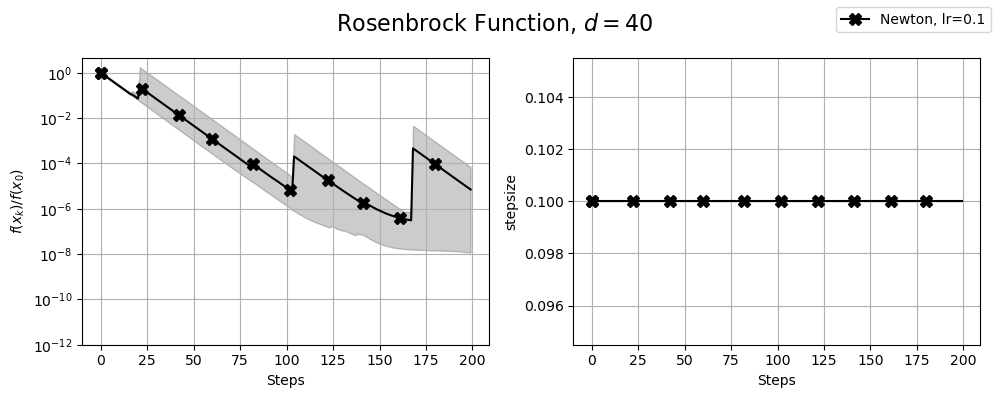

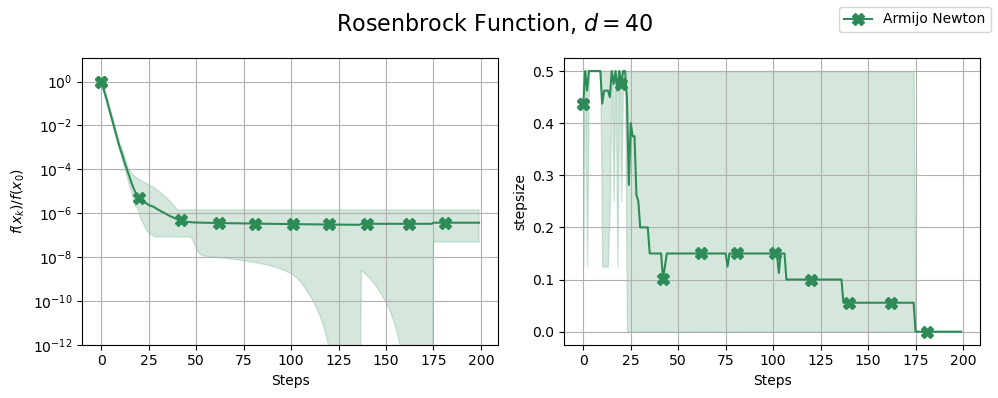

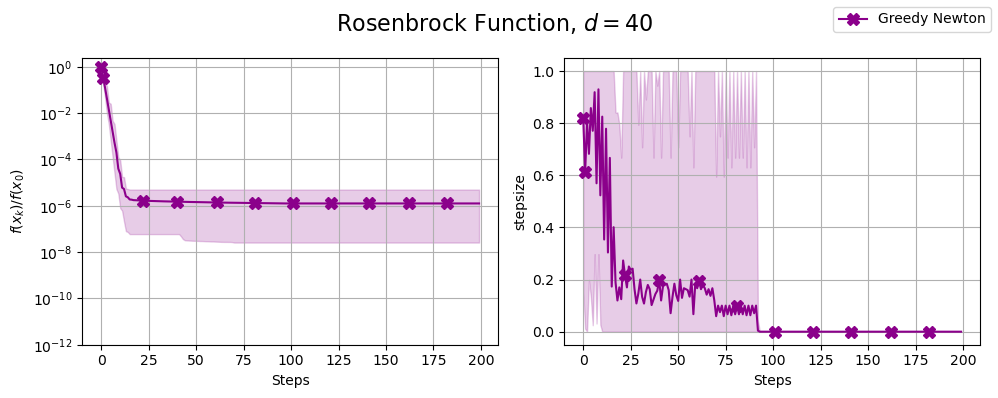

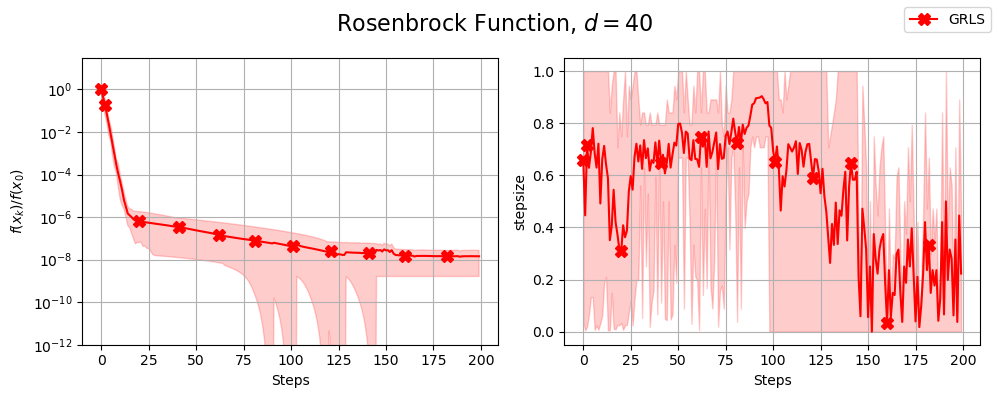

In [188]:
colors=["black", "seagreen", "darkmagenta", "red", "tab:purple"]

for hist, label, c in zip(histories, labels, colors):
        plotter(histories=[hist], 
                labels=[label],
                colors=[c],
                linestyles=["-", "--", "-.", ":", "-"],
                linewidths=[1.5, 1.0, 2.0, 2.0, 1.0],
                markers=["X", ".", "v", "s", "p"],
                markersizes=[8, 10, 8, 6, 6],
                suptitle=r"Rosenbrock Function, $d={0}$".format(dim),
                f_star=0.0,
                ylims=[[1e-12, 0.0]],)
                # filename=f"rosenbrock_linesearch.pdf")

In [11]:
def train_loop_rn(w_0: np.array, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # parameters
    w = w_0.copy()
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = RosenbrockFunction()
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
    loss = np.inf
    for step in range(n_steps):
        
        if loss <= 1e-12:
            continue

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)

        optim.step(oracle=loss_function)

        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )}")
        history["loss"].append(loss)
        history["grad_norm_sq"].append(np.linalg.norm(grad) ** 2)
        history["time"].append(time)
    
    return history

In [12]:
hyperparams = {
    "DampedNewton": {"lr": -1.0},
    "AICN": {"L_est": 1.0},
    "RootNewton": {"q": 2.0, "L_est": 0.5},
    "SimpliReg": {"beta": 0.001, "sigma": 1.0},
    "GradientMethod": {"L_est": 1.0}, 
    "UniversalNewton": {"sigma_0": 1.0, "c": 3.5},
}

In [13]:
def plotter_rn(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markersizes=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, ylims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if f_star is None:
        f_star = np.min([x["loss"] for x in histories])
    else:
        f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m, ms in zip(histories, labels, colors, linestyles, linewidths, markers, markersizes):
        f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
    
        markevery = [0, ] + [x + np.random.randint(0, 2) for x in range(0, len(history["loss"]) - 2, len(history["loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markersize=ms)
        ax[1].semilogy(history["time"], f_suboptim, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markersize=ms)


    if f_star.sum() == 0.0:
        ax[0].set_ylabel(r"$f(x_k)/f(x_0)$")
        ax[1].set_ylabel(r"$f(x_k)/f(x_0)$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")
        ax[1].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")

    ax[0].set_xlabel("Steps")
    ax[1].set_xlabel("Time, sec")
    
    if xlims is not None:
        ax[0].set_xlim(left=xlims[0][0], right=xlims[0][1])
        ax[1].set_xlim(left=xlims[1][0], right=xlims[1][1])

    if ylims is not None:
        ax[0].set_ylim(bottom=ylims[0][0], top=ylims[0][1])
        ax[1].set_ylim(bottom=ylims[1][0], top=ylims[1][1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show() 

In [14]:
np.random.seed(0)

n_steps = 200
dim = 40
w_0 = np.random.randn(dim) * 20

/home/farshed.abdukhakimov/projects/root-newton/methods.py:72: RuntimeWarning: invalid value encountered in sqrt
  g = np.sqrt(grad.dot(n))


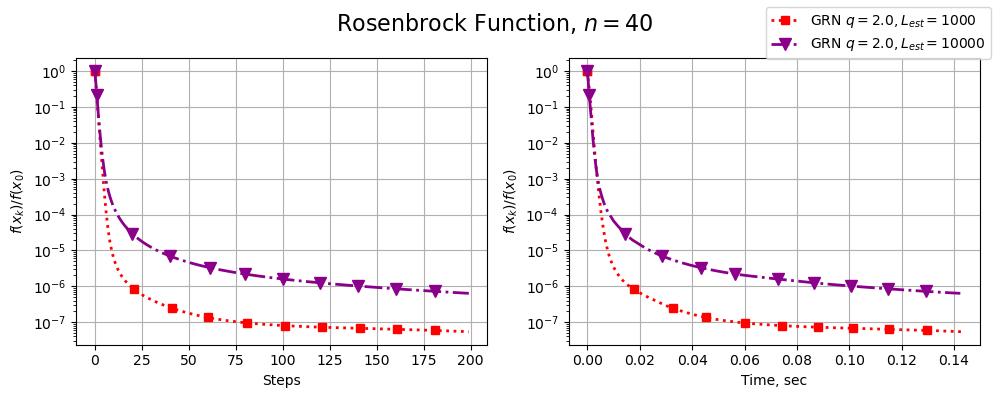

In [28]:
np.random.seed(0)

histories = []
labels = []

# GradRegNewton
q = 2.0
L_est = 0.0001
for L_est in [1000, 10_000]:
    hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
    histories.append(hist)
    labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

plotter_rn(histories=histories, 
        labels=labels,
        colors=["red", "darkmagenta", "seagreen", "royalblue"],
        linestyles=[":", "-.", "--", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.0],
        markers=["s", "v", "s", "s"],
        markersizes=[6, 8, 6, 6],
        suptitle=r"Rosenbrock Function, $n={0}$".format(dim),
        threshold=0.0,
        f_star=0.0,)
        # ylims=[(1e-12, 5.0), (1e-12, 5.0)],
        # xlims=[(-1.0, 30), (-0.002, 0.04)],)
        # filename=f"polytope_rn_p_{p}.pdf")

In [29]:
np.random.seed(0)

histories = []
labels = []

# Root Newton
q = 2.0
L_est = 0.0001
hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = 0.001
hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = 2.0
L_est = 1000
hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

/home/farshed.abdukhakimov/projects/root-newton/methods.py:122: RuntimeWarning: invalid value encountered in scalar power
  g = grad.dot(n) ** 0.5


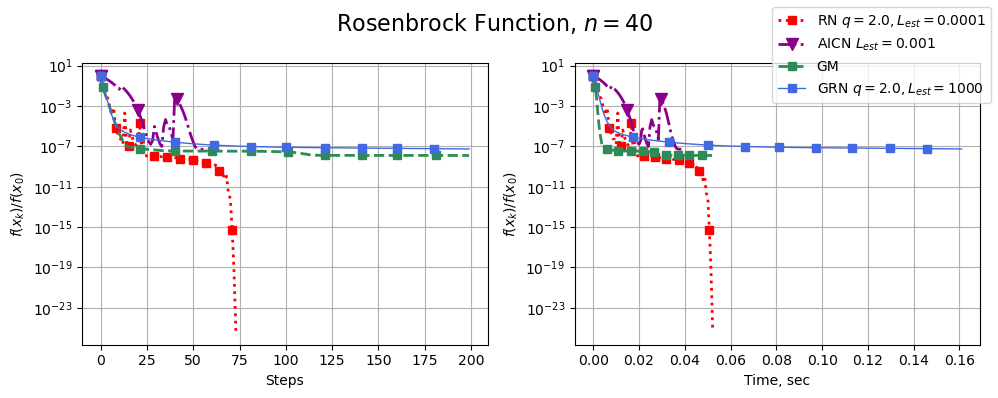

In [30]:
plotter_rn(histories=histories, 
        labels=labels,
        colors=["red", "darkmagenta", "seagreen", "royalblue"],
        linestyles=[":", "-.", "--", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.0],
        markers=["s", "v", "s", "s"],
        markersizes=[6, 8, 6, 6],
        suptitle=r"Rosenbrock Function, $n={0}$".format(dim),
        threshold=0.0,
        f_star=0.0,)
        # ylims=[(1e-12, 5.0), (1e-12, 5.0)],
        # xlims=[(-1.0, 30), (-0.002, 0.04)],)
        # filename=f"polytope_rn_p_{p}.pdf")

In [21]:
np.random.seed(0)


histories = []
labels = []

# Damped Newton
lr = 0.01
hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
histories.append(hist)
labels.append(f"Newton, lr={lr}")

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):
    hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, {0}".format(l))

# Universal Newton
sigma_0 = hyperparams["UniversalNewton"]["sigma_0"]
c = hyperparams["UniversalNewton"]["c"]
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop_rn(w_0=w_0, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, {0}".format(l))

/home/farshed.abdukhakimov/projects/root-newton/methods.py:378: RuntimeWarning: invalid value encountered in scalar power
  


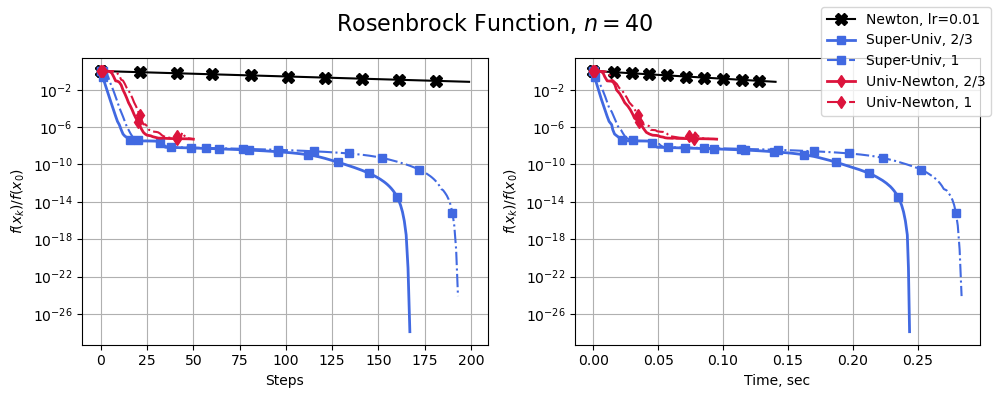

In [20]:
plotter_rn(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-."],
        linewidths=[1.5, 2.0, 1.5, 2.0, 1.5],
        markers=["X", "s", "s", "d", "d"],
        markersizes=[8, 6, 6, 6, 6],
        suptitle=r"Rosenbrock Function, $n={0}$".format(dim),
        threshold=0.0,
        f_star=0.0,)
        # ylims=[(1e-14, 10.0), (1e-14, 10.0)],
        # xlims=[(-3.0, 70), (-0.02, 0.45)],)
        # filename=f"polytope_univ_p_{p}.pdf")
